In [1]:
import pennylane as qml
from pennylane import numpy as np

# ตั้งค่า quantum device จำลอง (2 qubits, 1000 shots)
n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits, shots=1000)

# สร้างวงจร quantum generator
def quantum_generator(weights):
    for i in range(n_qubits):
        qml.RY(weights[i], wires=i)       # Rotation ตาม weights (parametric circuit)

    qml.CNOT(wires=[0, 1])                 # เพิ่ม entanglement

# Quantum circuit สำหรับสุ่มข้อมูล
@qml.qnode(dev)
def sample_data(weights):
    quantum_generator(weights)
    return qml.sample(wires=range(n_qubits))  # สุ่มข้อมูลออกมาเป็น [0,1], [1,0] ฯลฯ

# ตั้งค่าน้ำหนักวงจร (weights)
weights = np.array([1.2, 0.7], requires_grad=True)

# เรียกใช้งาน circuit เพื่อสุ่มข้อมูลออกมา
samples = sample_data(weights)

# แสดงตัวอย่างข้อมูลจำลอง
print("ตัวอย่างข้อมูลจำลอง 10 ชุดแรก:")
print(samples[:10])

# แปลงเป็น array เพื่อใช้เป็น synthetic dataset
synthetic_data = np.array(samples)


ตัวอย่างข้อมูลจำลอง 10 ชุดแรก:
[[1 1]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]]


จำนวนข้อมูลจำลองทั้งหมดที่ได้: 10000 ตัวอย่าง
ตัวอย่างข้อมูลจำลอง 10 ตัวแรก:
[[1 0]
 [1 0]
 [0 1]
 [1 1]
 [1 0]
 [1 1]
 [1 0]
 [1 0]
 [1 1]
 [1 0]]


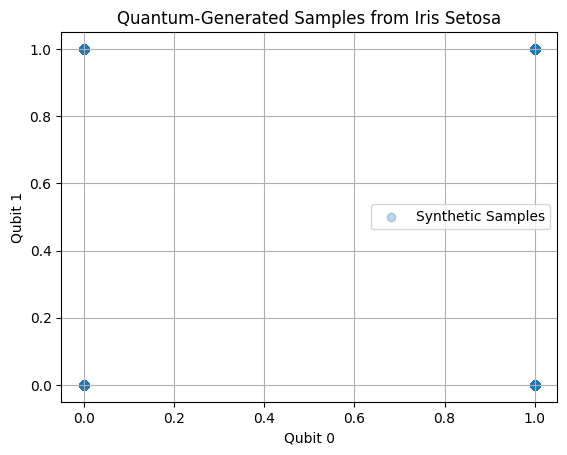

In [2]:
import pennylane as qml
from pennylane import numpy as np
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# โหลดข้อมูล Iris
data = load_iris()
X = data.data     # ใช้เฉพาะ features
y = data.target   # target: 0=setosa, 1=versicolor, 2=virginica

# เลือกแค่ class 0 (setosa) เพื่อทดลอง
X_small = X[y == 0][:10]   # เลือกแค่ 10 ตัวอย่างแรก
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_small[:, :2])  # ใช้แค่ 2 features แรก และปรับ scale อยู่ใน [0,1]

# สร้าง quantum device
dev = qml.device("default.qubit", wires=2, shots=1000)

# Quantum circuit generator
def encoder(x):
    for i in range(2):
        qml.RY(np.pi * x[i], wires=i)  # Angle encoding
    qml.CNOT(wires=[0, 1])

@qml.qnode(dev)
def quantum_sampler(x):
    encoder(x)
    return qml.sample(wires=[0, 1])  # วัดสถานะเป็น [0,1], [1,0], ฯลฯ

# สร้างข้อมูลจำลองจากแต่ละ sample จริง
synthetic_data = []

for i, x in enumerate(X_scaled):
    samples = quantum_sampler(x)
    for s in samples:
        synthetic_data.append(s)

synthetic_data = np.array(synthetic_data)

# แสดงผลข้อมูลจำลอง
print(f"จำนวนข้อมูลจำลองทั้งหมดที่ได้: {len(synthetic_data)} ตัวอย่าง")
print("ตัวอย่างข้อมูลจำลอง 10 ตัวแรก:")
print(synthetic_data[:10])

# แสดง scatter plot
plt.scatter(synthetic_data[:, 0], synthetic_data[:, 1], alpha=0.3, label='Synthetic Samples')
plt.title("Quantum-Generated Samples from Iris Setosa")
plt.xlabel("Qubit 0")
plt.ylabel("Qubit 1")
plt.legend()
plt.grid(True)
plt.show()


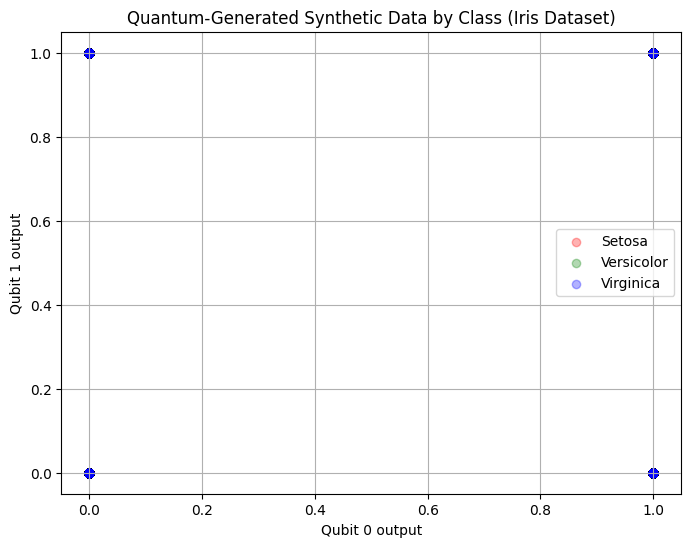

In [3]:
import pennylane as qml
from pennylane import numpy as np
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# === 1. Load and prepare data ===
data = load_iris()
X = data.data      # 4 features
y = data.target    # 0, 1, 2

# Use only 2 features for encoding (for 2 qubits)
X_2f = X[:, :2]

# Normalize features to [0,1]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_2f)

# Group data by class
class_data = {
    0: X_scaled[y == 0][:10],  # Setosa
    1: X_scaled[y == 1][:10],  # Versicolor
    2: X_scaled[y == 2][:10],  # Virginica
}

# === 2. Quantum setup ===
n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits, shots=200)

def encoder(x):
    for i in range(n_qubits):
        qml.RY(np.pi * x[i], wires=i)
    qml.CNOT(wires=[0, 1])  # simple entanglement

@qml.qnode(dev)
def quantum_sampler(x):
    encoder(x)
    return qml.sample(wires=range(n_qubits))

# === 3. Generate synthetic data by class ===
synthetic_data_by_class = {}

for cls, samples in class_data.items():
    synthetic_samples = []
    for x in samples:
        results = quantum_sampler(x)
        for r in results:
            synthetic_samples.append([r[0], r[1]])  # binary vector
    synthetic_data_by_class[cls] = np.array(synthetic_samples)

# === 4. Plotting ===
colors = ['red', 'green', 'blue']
labels = ['Setosa', 'Versicolor', 'Virginica']

plt.figure(figsize=(8,6))
for cls in synthetic_data_by_class:
    data = synthetic_data_by_class[cls]
    plt.scatter(data[:, 0], data[:, 1], alpha=0.3, label=labels[cls], color=colors[cls])

plt.title("Quantum-Generated Synthetic Data by Class (Iris Dataset)")
plt.xlabel("Qubit 0 output")
plt.ylabel("Qubit 1 output")
plt.legend()
plt.grid(True)
plt.show()


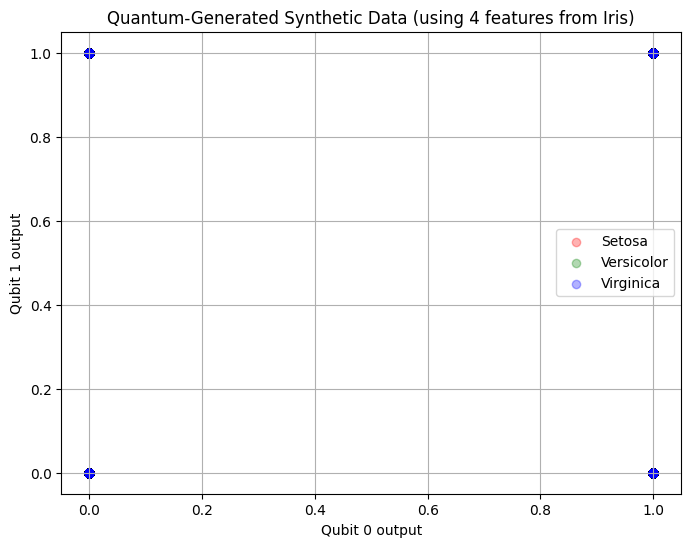

In [4]:
import pennylane as qml
from pennylane import numpy as np
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# === 1. Load and scale data ===
data = load_iris()
X = data.data      # shape (150, 4)
y = data.target    # 0=setosa, 1=versicolor, 2=virginica

# Normalize features to [0,1]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Group data by class (ใช้แค่บางตัวอย่างต่อ class เพื่อความเร็ว)
class_data = {
    0: X_scaled[y == 0][:10],
    1: X_scaled[y == 1][:10],
    2: X_scaled[y == 2][:10],
}

# === 2. Quantum setup: ใช้ 4 Qubits ===
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits, shots=200)

def encoder(x):
    for i in range(n_qubits):
        qml.RY(np.pi * x[i], wires=i)
    # เพิ่ม entanglement
    for i in range(n_qubits - 1):
        qml.CNOT(wires=[i, i+1])

@qml.qnode(dev)
def quantum_sampler(x):
    encoder(x)
    return qml.sample(wires=range(n_qubits))  # ได้ output เป็น binary vector ยาว 4 บิต

# === 3. สร้างข้อมูลจำลองด้วย Quantum Sampling ===
synthetic_data_by_class = {}

for cls, samples in class_data.items():
    synthetic_samples = []
    for x in samples:
        results = quantum_sampler(x)
        for r in results:
            synthetic_samples.append(r)  # r เป็น binary vector ขนาด 4
    synthetic_data_by_class[cls] = np.array(synthetic_samples)

# === 4. แสดงผลแบบ scatter (เลือกแค่ 2 มิติแสดง) ===
colors = ['red', 'green', 'blue']
labels = ['Setosa', 'Versicolor', 'Virginica']

plt.figure(figsize=(8,6))
for cls in synthetic_data_by_class:
    data = synthetic_data_by_class[cls]
    plt.scatter(data[:, 0], data[:, 1], alpha=0.3, label=labels[cls], color=colors[cls])

plt.title("Quantum-Generated Synthetic Data (using 4 features from Iris)")
plt.xlabel("Qubit 0 output")
plt.ylabel("Qubit 1 output")
plt.legend()
plt.grid(True)
plt.show()


In [8]:
import pennylane as qml
from pennylane import numpy as np
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# === Load และเตรียมข้อมูล ===
data = load_iris()
X = data.data
y = data.target
X_scaled = MinMaxScaler().fit_transform(X[:, :2])  # ใช้ 2 features

X_train = X_scaled[y == 0][:5]  # ใช้แค่ class 0 (Setosa) ตัวอย่างน้อยๆ

# === Quantum device ===
n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits, shots=500)

# === VQC Generator ===
def vqc(params):
    for i in range(n_qubits):
        qml.RY(params[i], wires=i)
    qml.CNOT(wires=[0, 1])
    for i in range(n_qubits):
        qml.RX(params[i + 2], wires=i)

@qml.qnode(dev)
def circuit(params):
    vqc(params)
    return qml.probs(wires=[0, 1])  # เป็น probability vector (4 ค่า)

# === Loss: MSE ระหว่าง distribution ที่ได้กับ target (ค่าเฉลี่ยจากข้อมูลจริง)
def target_distribution(X_train):
    counts = np.zeros(4)
    for x in X_train:
        # ใช้ angle encoding แบบง่าย
        x_angle = np.pi * x
        for i in range(n_qubits):
            qml.RY(x_angle[i], wires=i)
        qml.CNOT(wires=[0, 1])
        results = qml.sample(wires=[0, 1])
        results = np.array(results)  # Convert SampleMP to numpy array
        # Ensure results is always 2D
        if results.ndim == 1:
            results = results.reshape(1, -1)
        for r in results:
            idx = int(r[0]*2 + r[1])
            counts[idx] += 1
    return counts / np.sum(counts)

target_probs = target_distribution(X_train)

def cost(params):
    probs = circuit(params)
    return np.sum((probs - target_probs)**2)

# === ฝึกพารามิเตอร์ของวงจร VQC ===
params = np.random.uniform(0, np.pi, 4, requires_grad=True)
opt = qml.GradientDescentOptimizer(stepsize=0.4)

for i in range(50):
    params = opt.step(cost, params)
    if i % 10 == 0:
        print(f"Iter {i} | Loss: {cost(params):.6f}")

# === สุ่มข้อมูลจากวงจรที่ฝึกแล้ว ===
@qml.qnode(dev)
def generate_samples(params):
    vqc(params)
    return qml.sample(wires=[0, 1])

samples = generate_samples(params)
print("Synthetic samples:")
print(samples[:10])

# === พล็อตผลลัพธ์ ===
results = np.array(samples)
plt.title("VQC-Generated Data (2 qubits)")
plt.scatter(results[:,0], results[:,1], alpha=0.3, color='blue')
plt.xlabel("Qubit 0")
plt.ylabel("Qubit 1")
plt.grid(True)
plt.show()


TypeError: iteration over a 0-d array

Iter 00 | Loss = 0.205374
Iter 10 | Loss = 0.046598
Iter 20 | Loss = 0.043574
Iter 30 | Loss = 0.029366
Iter 40 | Loss = 0.016730


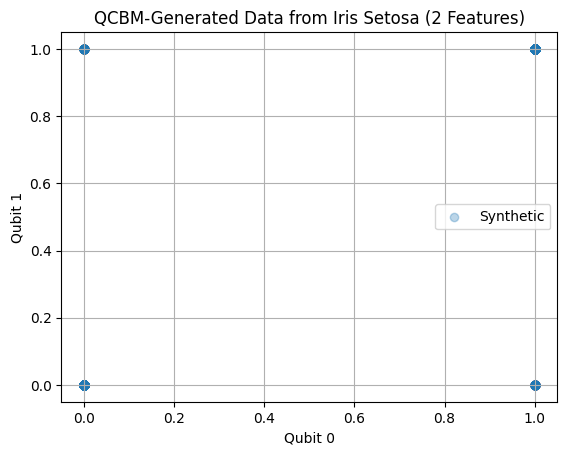

In [9]:
import pennylane as qml
from pennylane import numpy as np
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# === Load ข้อมูล Iris ===
X, y = load_iris(return_X_y=True)
X = X[y == 0][:50, :2]  # เอาเฉพาะ class 0 (Setosa) และ 2 features
X = MinMaxScaler().fit_transform(X)  # scale ให้อยู่ใน [0,1]

# === Convert real data → binary vectors (4 bins → 2 qubits)
def real_to_bin(x, bins=2):
    return (x * bins).astype(int).clip(0, bins - 1)

def get_data_distribution(X):
    counts = np.zeros(4)
    for x in X:
        b = real_to_bin(x)
        idx = b[0]*2 + b[1]  # map to index [0-3]
        counts[idx] += 1
    return counts / np.sum(counts)

data_probs = get_data_distribution(X)

# === QCBM setup ===
n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits, shots=1000)

def qcbm_layer(params):
    for i in range(n_qubits):
        qml.RY(params[i], wires=i)
    qml.CNOT(wires=[0, 1])
    for i in range(n_qubits):
        qml.RZ(params[i + 2], wires=i)

@qml.qnode(dev)
def qcbm_circuit(params):
    qcbm_layer(params)
    return qml.probs(wires=[0, 1])  # ได้ 4 ค่า (|00>, |01>, |10>, |11>)

# === Loss function: Mean Square Error
def loss(params):
    q_probs = qcbm_circuit(params)
    return np.sum((q_probs - data_probs)**2)

# === Training
params = np.random.uniform(0, 2*np.pi, size=4, requires_grad=True)
opt = qml.AdamOptimizer(stepsize=0.2)

for it in range(50):
    params = opt.step(loss, params)
    if it % 10 == 0:
        print(f"Iter {it:02d} | Loss = {loss(params):.6f}")

# === Generate synthetic data from trained QCBM
@qml.qnode(dev)
def sample_qcbm(params):
    qcbm_layer(params)
    return qml.sample(wires=[0, 1])

samples = sample_qcbm(params)

# === Plot results
results = np.array(samples)
plt.title("QCBM-Generated Data from Iris Setosa (2 Features)")
plt.scatter(results[:, 0], results[:, 1], alpha=0.3, label='Synthetic')
plt.xlabel("Qubit 0")
plt.ylabel("Qubit 1")
plt.grid(True)
plt.legend()
plt.show()


Step   0 | Loss: 0.259060
Step  10 | Loss: 0.071846
Step  20 | Loss: 0.056646
Step  30 | Loss: 0.058010
Step  40 | Loss: 0.054234
Step  50 | Loss: 0.051092
Step  60 | Loss: 0.059274
Step  70 | Loss: 0.057750
Step  80 | Loss: 0.057492
Step  90 | Loss: 0.046238


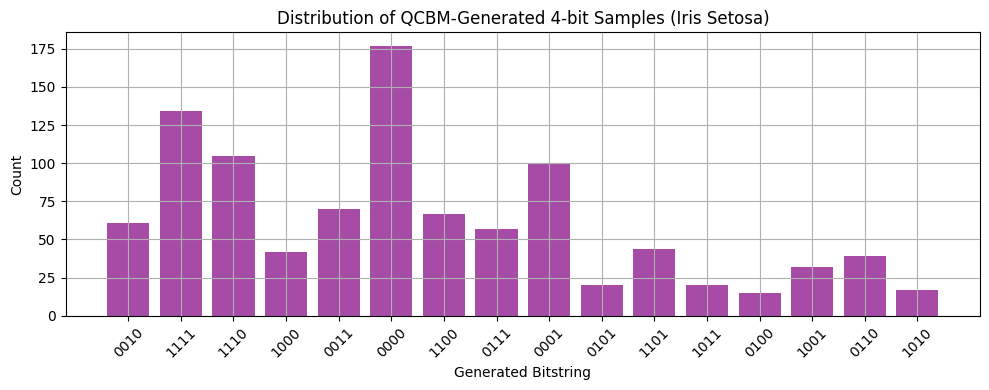

In [11]:
import pennylane as qml
from pennylane import numpy as np
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
import matplotlib.pyplot as plt

# === 1. Load และเตรียมข้อมูล ===
X, y = load_iris(return_X_y=True)
X = X[y == 0][:50]  # ใช้ class 0 (Setosa) 50 ตัว
X = MinMaxScaler().fit_transform(X)  # scale เป็น [0,1]

# === 2. แปลงข้อมูลเป็น 4-bit (1 บิตต่อฟีเจอร์)
def to_bitstring(x):
    return ''.join([str(int(i > 0.5)) for i in x])

bitstrings = [to_bitstring(x) for x in X]

# === 3. สร้าง distribution เป้าหมาย (16 states จาก 4-bit)
def target_distribution(bitstrings):
    counts = Counter(bitstrings)
    total = sum(counts.values())
    dist = np.zeros(16)
    for b, c in counts.items():
        idx = int(b, 2)
        dist[idx] = c / total
    return dist

target_probs = target_distribution(bitstrings)

# === 4. สร้าง QCBM วงจร (4 Qubits)
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits, shots=1000)

def qcbm_layer(params):
    for i in range(n_qubits):
        qml.RY(params[i], wires=i)
    for i in range(n_qubits - 1):
        qml.CNOT(wires=[i, i + 1])
    for i in range(n_qubits):
        qml.RZ(params[n_qubits + i], wires=i)

@qml.qnode(dev)
def qcbm_circuit(params):
    qcbm_layer(params)
    return qml.probs(wires=range(n_qubits))

# === 5. Loss (MSE ระหว่าง QCBM กับ distribution จริง)
def loss(params):
    probs = qcbm_circuit(params)
    return np.sum((probs - target_probs) ** 2)

# === 6. ฝึกวงจรด้วย Gradient Descent
params = np.random.uniform(0, np.pi, 8, requires_grad=True)  # 8 พารามิเตอร์ (RY+RZ)
opt = qml.AdamOptimizer(stepsize=0.3)

for step in range(100):
    params = opt.step(loss, params)
    if step % 10 == 0:
        print(f"Step {step:3d} | Loss: {loss(params):.6f}")

# === 7. สุ่มข้อมูลจากวงจร QCBM ที่ฝึกแล้ว
@qml.qnode(dev)
def sample_qcbm(params):
    qcbm_layer(params)
    return qml.sample(wires=range(n_qubits))

samples = sample_qcbm(params)

# แปลงจาก array → binary string
synthetic_bitstrings = [''.join(map(str, sample)) for sample in samples]

# === 8. แสดง histogram ของข้อมูลจำลอง
counts = Counter(synthetic_bitstrings)
labels = list(counts.keys())
values = [counts[k] for k in labels]

plt.figure(figsize=(10, 4))
plt.bar(labels, values, color='purple', alpha=0.7)
plt.title("Distribution of QCBM-Generated 4-bit Samples (Iris Setosa)")
plt.xlabel("Generated Bitstring")
plt.ylabel("Count")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [12]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# === ขั้นตอนก่อนหน้า: สร้าง MinMaxScaler จากข้อมูลจริง ===
from sklearn.datasets import load_iris
X, y = load_iris(return_X_y=True)
X = X[y == 0][:50]  # Iris Setosa
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# === bitstrings ที่ได้จาก QCBM ===
bitstrings = ['1010', '0101', '1111', '0000', '1001', '0110']  # ตัวอย่าง

# === แปลง bitstring เป็นค่าระดับกลางของ bin (0.25 / 0.75)
def bit_to_scaled_feature(bs):
    return [0.25 if b == '0' else 0.75 for b in bs]

# แปลงกลับเป็นข้อมูล feature จริง
def decode_bitstrings(bitstrings, scaler):
    scaled_features = np.array([bit_to_scaled_feature(bs) for bs in bitstrings])
    original_features = scaler.inverse_transform(scaled_features)
    return original_features

# === เรียกใช้ ===
decoded_features = decode_bitstrings(bitstrings, scaler)

# แสดงผล
for i, (bs, real_feat) in enumerate(zip(bitstrings, decoded_features)):
    print(f"{i+1}. Bitstring: {bs} → Iris features (approx): {real_feat.round(2)}")


1. Bitstring: 1010 → Iris features (approx): [5.42 2.82 1.68 0.22]
2. Bitstring: 0101 → Iris features (approx): [4.68 3.88 1.23 0.48]
3. Bitstring: 1111 → Iris features (approx): [5.42 3.88 1.68 0.48]
4. Bitstring: 0000 → Iris features (approx): [4.68 2.82 1.23 0.22]
5. Bitstring: 1001 → Iris features (approx): [5.42 2.82 1.23 0.48]
6. Bitstring: 0110 → Iris features (approx): [4.68 3.88 1.68 0.22]


In [13]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import load_iris
from collections import Counter
import pandas as pd

# === เตรียมข้อมูลจริง Iris สำหรับ scale ===
X_real, y_real = load_iris(return_X_y=True)
X_real = X_real[y_real == 0][:50]  # ใช้ class 0 (Setosa) เท่านั้น
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_real)

# === สมมุติว่าได้ bitstring จาก QCBM มาแล้ว ===
# (สามารถแทนด้วยผลลัพธ์จาก qml.sample)
bitstrings = ['1010', '0101', '1111', '0000', '1001', '0110',
              '1100', '0011', '0111', '0001', '1110', '0010'] * 10  # รวม 120 ตัวอย่าง

# === ฟังก์ชันแปลง bitstring → scaled features → original Iris features
def bit_to_scaled(bs):
    return [0.25 if b == '0' else 0.75 for b in bs]

def decode_bitstrings_to_iris(bitstrings, scaler):
    scaled_features = np.array([bit_to_scaled(bs) for bs in bitstrings])
    original_features = scaler.inverse_transform(scaled_features)
    return original_features

# === เรียกใช้ ===
decoded_data = decode_bitstrings_to_iris(bitstrings, scaler)

# === แสดงผลและบันทึกเป็น DataFrame ===
df = pd.DataFrame(decoded_data, columns=["sepal length", "sepal width", "petal length", "petal width"])
df["label"] = "Setosa (QCBM)"  # ติดป้ายว่าเป็นข้อมูลจำลอง

print(df.head())

# === (ทางเลือก) บันทึกเป็น CSV ===
df.to_csv("qcbm_iris_synthetic.csv", index=False)


   sepal length  sepal width  petal length  petal width          label
0         5.425        2.825         1.675        0.225  Setosa (QCBM)
1         4.675        3.875         1.225        0.475  Setosa (QCBM)
2         5.425        3.875         1.675        0.475  Setosa (QCBM)
3         4.675        2.825         1.225        0.225  Setosa (QCBM)
4         5.425        2.825         1.225        0.475  Setosa (QCBM)
